# UDLR Two Dimentional Vision System Examples

In [1]:
import numpy as np
from pyESN import ESN
from matplotlib import pyplot as plt
%matplotlib inline
import csv
import networkx as nx
import networkx as nx
from matplotlib import pyplot, patches

from utils import *

In [25]:
def generate_liquid(n_inputs):
    G = generate_ffbo_graph()
    n_reservoir = G.number_of_nodes()
    input_names =['home', 'A',  'B', 'C', 'D', 'E',  'F',  'J',   'K'   ,'L'   ,'P'   ,'Q'   ,'R']

    # Create Input Matrix
    input_matrix = np.zeros((n_reservoir, n_inputs))
    for j,c in enumerate(input_names):
        for i,n in enumerate(G.nodes()):
            if 'L1' in n or  'L2' in n or  'L4' in n:
                if c in n:
                    input_matrix[i,j] = 1                

    #Create a list of network outputs that can be used to train upon
    # We focus oon the T4 and Tm* neurons
    output_node_matrix = np.zeros((input_matrix.shape[0],input_matrix.shape[1]))

    for i,n in enumerate(G.nodes()):
        if 'Tm3' in n or 'Mi1' in n or 'Mi9' in n or 'Mi4' in n or 'T4' in n:    
            output_node_matrix[i,:] = 1
    
    output_node_matrix =  output_node_matrix[:,0].T
            
    adjacency_matrix = np.array(nx.adjacency_matrix(G, weight='weight').todense())
    adjacency_matrix[adjacency_matrix>0] = 1
    adjacency_matrix[adjacency_matrix<1] = 0

    return n_reservoir, adjacency_matrix,input_matrix,output_node_matrix
            
def analyse_results(results):
    """ reurn the proportion of correct trials
        results : nested dictionary where keys are the expected trial_results: {class:results}
    """
    performances = {}
    for c in results:
        target = results[c][c]
        others = set(results[c].keys())
        others.remove(c)
        
        other_data = np.vstack([results[c][d] for d in others])
        ratio =  sum(target > np.max(other_data)) / (len(target)*1.0)
        performances[c] = ratio
        print performances
    performance  = np.mean(performances.values())

    return performance
    

In [5]:
def bars_signal(n=100,on_size=10,off_size=10,on_val=1,off_val=0):
    image = np.zeros((n,n))
    
    i = 0
    while i < n:
        image[i:i+on_size] = on_val
        i = i+on_size
        image[i:i+off_size] = off_val
        i = i+off_size
    
    return image

def single_trial(image, centers,input_class,hex_radius =0.1):

    input_data = []
    input_class = np.array([input_class for _ in centers])
    
    for m in centers:
        ps,d,names = extract_data(image,(2,2),m, hex_radius)
        input_data.append(d)

    return np.array(input_data), input_class, ps, names



#image = bars_signal(n=100)
image = bars_signal(n=100,on_size=3,off_size=10,on_val = 0.5,off_val = 0.1)


def generate_centers(trial_length = 100,path_start = 0.2,path_end = 0.8):
    path_steps = (path_end-path_start)/trial_length
    centers = [(n,n) for n in np.arange(path_start,path_end,path_steps)]
    return centers


In [37]:
def generate_data(trial_length = 100,path_start = 0.2, path_end = 0.8, n_repeats = 30, shuffle = True):

    image = bars_signal(n=100,on_size=3,off_size=10,on_val = 0.5,off_val = 0.1)

    trial_length =trial_length
    
    path_start = path_start
    path_end = path_end
    
    centers = {}
    # Move X directions
    centers[0] = generate_centers(trial_length = trial_length,path_start = path_start,path_end = path_end)
    # Move Y directions
    centers[1] = generate_centers(trial_length = trial_length,path_start = path_start,path_end = path_end)
    # Move X directions
    centers[2] = generate_centers(trial_length = trial_length,path_start = path_end,path_end = path_start)
    # Move Y directions
    centers[3] = generate_centers(trial_length = trial_length,path_start = path_end,path_end = path_start)


    images = {}

    n_outputs = 4
    n_trials = n_outputs * n_repeats

    trials = []
    
    t = 0
    for i in np.arange(n_trials):
        trials.append(t)
        t+=1
        if t == n_outputs:t=0

    if shuffle:
        from random import shuffle
        shuffle(trials)


    trial_data = []
    trial_class = []
    image_backup = image.copy()

    for trial in trials:
        cs = centers[trial]

        if trial == 1  or trial == 3: 
            image = image_backup.T.copy()
        else:
            image = image_backup.copy()
        images[trial] = image
        data, classes, ps, names = single_trial(image, cs,input_class=trial,hex_radius =0.03)

        trial_data.append(data)
        trial_class.append(classes)
        
        experiment_classes = np.hstack(trial_class)

        experiment_targets= -np.ones((n_outputs,experiment_classes.shape[0]))
        for i,c in enumerate(experiment_classes):
            experiment_targets[c,i] = 1

        experiment_data = np.ones((trial_data[0].shape[0]*len(trial_data),trial_data[0].shape[1]))

        for i,d in enumerate(trial_data):
            experiment_data[i*trial_data[0].shape[0]:(i+1)*trial_data[0].shape[0],:] = d

        experiment_data = experiment_data.T
        
    return experiment_targets, experiment_data, trials


In [54]:
def create_esn(experiment_targets, experiment_data, trials):

    trainlen = experiment_targets.shape[1]/2
    future =  experiment_targets.shape[1]/2
    full = trainlen + future

    # Simulation Data
    n_inputs =experiment_data.shape[0]
    n_outputs = experiment_targets.shape[0]

    n_reservoir, matrix ,input_matrix,o_nodes =  generate_liquid(n_inputs)

    esn = ESN(n_inputs = n_inputs,
              n_outputs = n_outputs,
              n_reservoir = n_reservoir,
              spectral_radius = 1.05,
              #noise = 0.01,
              random_state=42,
              teacher_forcing=False,
              matrix=matrix,
              input_matrix = input_matrix*10
              )

    pred_training = esn.fit(experiment_data[:trainlen].T,experiment_targets[:trainlen].T,True,o_nodes)

    # Generate Output
    prediction = esn.predict(experiment_data[:,trainlen:trainlen+future].T)

    return prediction

    

In [26]:
def analyse_data(trials,n_outputs, trial_length, prediction):
    prediction_classes = np.array(trials[-(len(trials)/2):])
    #prediction_classes = prediction_classes[2:]

    classes = np.arange(n_outputs)

    results = {c:{o: [] for o in classes} for c in classes }

    for i,c in enumerate(prediction_classes):

        data = prediction[i*trial_length:(i*trial_length)+trial_length,:]

        for cl in classes:
            results[c][cl].append(sum(data[:,cl]))

    return results



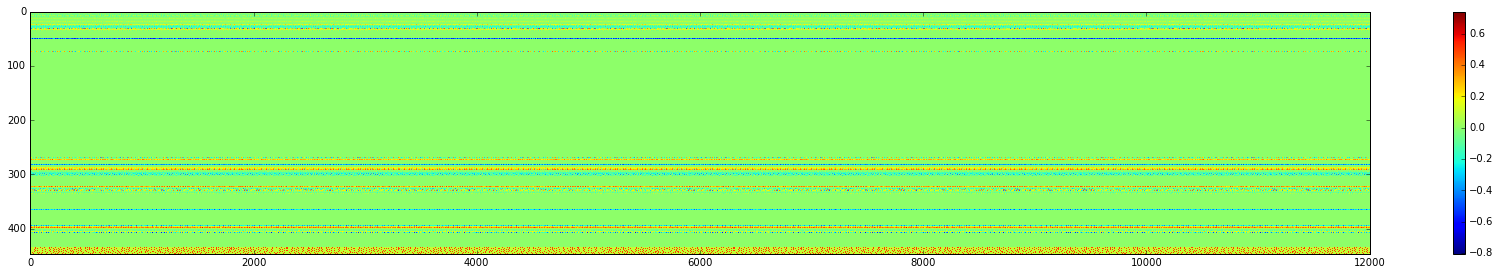

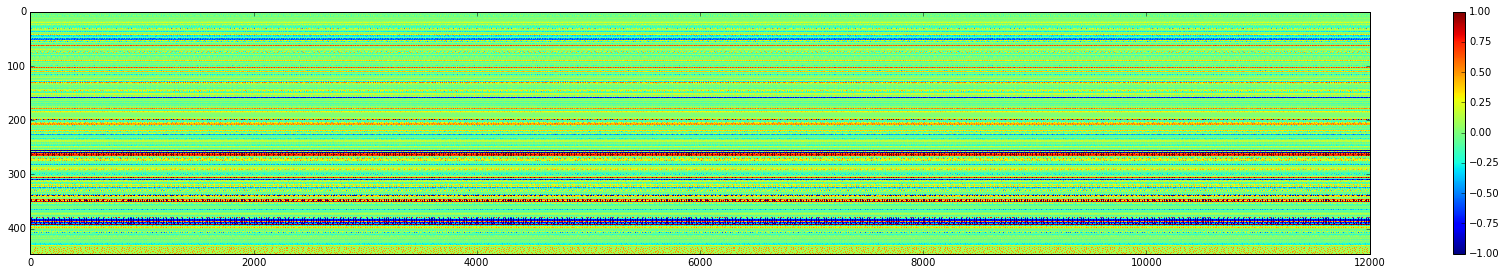

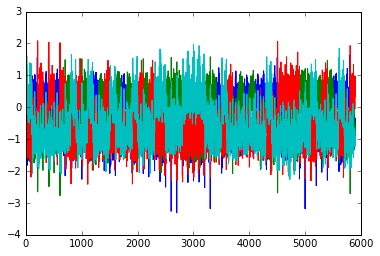

{0: 1.0}
{0: 1.0, 1: 1.0}
{0: 1.0, 1: 1.0, 2: 1.0}
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [81]:
# 1. Define Experimental Input / Output
trial_length = 100

experiment_targets, experiment_data, trials = generate_data(trial_length = trial_length,path_start = 0.2, path_end = 0.8, n_repeats = 30, shuffle = True)


# 2. Create Network

prediction = create_esn(experiment_targets, experiment_data, trials)
plt.show()
plt.plot(prediction[100:])
plt.show()

# 4. Analyse result
n_outputs = prediction.shape[1]
results =  analyse_data(trials,n_outputs, trial_length, prediction)
outcome = analyse_results(results)

In [82]:
results

{0: {0: [24.53970921677052,
   30.66285159091273,
   34.636570258558315,
   36.837312532259304,
   32.37170907536619,
   31.17439601965065,
   33.477139199357715,
   32.79509093805087,
   30.54810550814101,
   31.368243659132354,
   35.205424108625124,
   33.061458713995876,
   32.188002336953964,
   31.8337777223164],
  1: [-82.5794388536823,
   -94.13597915443793,
   -83.54258161542593,
   -79.90621861919193,
   -92.88048741216899,
   -83.28791311381421,
   -84.02221068129792,
   -81.10632411310407,
   -82.15061503711057,
   -81.53168468411226,
   -87.38897143227567,
   -93.31282382419154,
   -81.40124635391273,
   -90.29563405962014],
  2: [-74.38865632222843,
   -54.104674224904784,
   -58.80181649787915,
   -60.64959265111729,
   -56.63703166628771,
   -60.65657641190341,
   -61.535236549866475,
   -59.465796872684955,
   -60.52617214721139,
   -61.59931553044902,
   -57.20450364393239,
   -56.10061495724098,
   -62.33891399512474,
   -56.61858577260089],
  3: [-64.56959318658865,

In [52]:
class MyESN(object):
    def __init__(self):
        
        self.trial_length = 100
        
        #data generation
        self.trial_length = 100
        self.path_start = 0.2
        self.path_end = 0.8
        self.n_repeats = 30
        self.shuffle_trials = True
        
        self.n_outputs = 4
        self.n_inputs = 13
        self.n_reservoir = 434
        
        self.n_trials = self.n_outputs * self.n_repeats
        
        
        # ESN
        self.show_state = False
        self.spectral_radius = 1.05
        self.noise = 0.00
        self.random_state = 42
        self.input_multiplier = 10
        
        #self.create_experiment()
    
    def create_experiment(self):
            
            self.create_esn()
            self.generate_data()
            self.fit()
            self.predict()
            self.analyse_results()
            
    
    def generate_data(self):

        image = bars_signal(n=100,on_size=3,off_size=10,on_val = 0.5,off_val = 0.1)

    
        centers = {}
        # Move X directions
        centers[0] = generate_centers(trial_length = self.trial_length,path_start = self.path_start,path_end = self.path_end)
        # Move Y directions
        centers[1] = generate_centers(trial_length = self.trial_length,path_start = self.path_start,path_end = self.path_end)
        # Move X directions
        centers[2] = generate_centers(trial_length = self.trial_length,path_start = self.path_end,path_end = self.path_start)
        # Move Y directions
        centers[3] = generate_centers(trial_length = self.trial_length,path_start = self.path_end,path_end = self.path_start)

        # store data for inspection
        self.centers = centers
        self.images = {}
        self.trials = []

        # create trials array
        t = 0
        for i in np.arange(self.n_trials):
            self.trials.append(t)
            t+=1
            if t == self.n_outputs:t=0

        if self.shuffle_trials:
            from random import shuffle
            shuffle(self.trials)


        self.trial_data = []
        self.trial_class = []
        image_backup = image.copy()

        for trial in self.trials:
            cs = centers[trial]

            if trial == 1  or trial == 3: 
                image = image_backup.T.copy()
            else:
                image = image_backup.copy()
                
            self.images[trial] = image
            data, classes, ps, names = single_trial(image, cs,input_class=trial,hex_radius =0.03)

            self.trial_data.append(data)
            self.trial_class.append(classes)

            self.experiment_classes = np.hstack(self.trial_class)

            self.experiment_targets= -np.ones((self.n_outputs,self.experiment_classes.shape[0]))
            
            for i,c in enumerate(self.experiment_classes):
                self.experiment_targets[c,i] = 1

            self.experiment_data = np.ones((self.trial_data[0].shape[0]*len(self.trial_data),self.trial_data[0].shape[1]))

            for i,d in enumerate(self.trial_data):
                self.experiment_data[i*self.trial_data[0].shape[0]:(i+1)*self.trial_data[0].shape[0],:] = d

            self.experiment_data = self.experiment_data.T
            
            self.trainlen = self. experiment_targets.shape[1]/2
            self.future =  self.experiment_targets.shape[1]/2
        
        
        

        

    
    def create_esn(self):        

        self.generate_liquid()

        self.esn = ESN(n_inputs = self.n_inputs,
                  n_outputs = self.n_outputs,
                  n_reservoir = self.n_reservoir,
                  spectral_radius = self.spectral_radius,
                  noise = self.noise,
                  random_state=self.random_state,
                  teacher_forcing=False,
                  matrix=self.adjacency_matrix,
                  input_matrix = self.input_matrix*self.input_multiplier
                  )

    def fit(self):
        
        pred_training = self.esn.fit(self.experiment_data[:self.trainlen].T,self.experiment_targets[:self.trainlen].T,self.show_state,self.output_node_matrix)
    
    def predict(self):
        
        self.prediction = self.esn.predict(self.experiment_data[:,self.trainlen:self.trainlen+self.future].T)
        
        prediction_classes = np.array(self.trials[-self.future:])


        self.analyse_data()




    def analyse_data(self):
        # TODO: Remove assumption of 5050 split
        prediction_classes = np.array(self.trials[-(len(self.trials)/2):])
        #prediction_classes = prediction_classes[2:]

        classes = np.arange(self.n_outputs)

        results = {c:{o: [] for o in classes} for c in classes }

        for i,c in enumerate(prediction_classes):

            data = self.prediction[i*self.trial_length:(i*self.trial_length)+self.trial_length,:]

            for cl in classes:
                results[c][cl].append(sum(data[:,cl]))

        self.results = results


        
    
    def generate_liquid(self):
        self.G = generate_ffbo_graph()
        self.n_reservoir = self.G.number_of_nodes()
        self.input_names =['home', 'A',  'B', 'C', 'D', 'E',  'F',  'J',   'K'   ,'L'   ,'P'   ,'Q'   ,'R']

        # Create Input Matrix
        self.input_matrix = np.zeros((self.n_reservoir, self.n_inputs))
        for j,c in enumerate(self.input_names):
            for i,n in enumerate(self.G.nodes()):
                if 'L1' in n or  'L2' in n or  'L4' in n:
                    if c in n:
                        self.input_matrix[i,j] = 1                

        #Create a list of network outputs that can be used to train upon
        # We focus oon the T4 and Tm* neurons
        self.output_node_matrix = np.zeros((self.input_matrix.shape[0],self.input_matrix.shape[1]))

        for i,n in enumerate(self.G.nodes()):
            if 'Tm3' in n or 'Mi1' in n or 'Mi9' in n or 'Mi4' in n or 'T4' in n:    
                self.output_node_matrix[i,:] = 1

        self.output_node_matrix = self. output_node_matrix[:,0].T

        self.adjacency_matrix = np.array(nx.adjacency_matrix(self.G, weight='weight').todense())
        self.adjacency_matrix[self.adjacency_matrix>0] = 1
        self.adjacency_matrix[self.adjacency_matrix<1] = 0

        #return n_reservoir, adjacency_matrix,input_matrix,output_node_matrix

    def analyse_results(self):
        """ reurn the proportion of correct trials
            results : nested dictionary where keys are the expected trial_results: {class:results}
        """
        performances = {}
        for c in self.results:
            target = self.results[c][c]
            others = set(self.results[c].keys())
            others.remove(c)

            other_data = np.vstack([self.results[c][d] for d in others])
            ratio =  sum(target > np.max(other_data)) / (len(target)*1.0)
            
            
            performances[c] = ratio
        performance  = np.mean(performances.values())
        self.performance = performance
        return performance
    

        

In [53]:
x = MyESN()
x.input_multiplier=0.1
x.create_experiment()
x.performance

0.297979797979798

In [66]:

def graph_input_multipliers(input_multipliers, n_reps= 5, spectral_radius=1,plot=False):

    df_spectral_radius = pd.DataFrame(columns=["performance", "input_multiplier", "spectral_radius"])

    n_steps = input_multipliers.shape[0]
    n_reps = 5

    print "steps = %s" % (n_reps*n_steps)

    for r in np.arange(n_reps):
        for i,x in enumerate(input_multipliers):
            esn = MyESN()
            esn.input_multiplier = x
            esn.random_state = np.random.randint(10000)
            esn.spectral_radius=spectral_radius
            esn.create_experiment()

            df_input_multiplier = df_input_multiplier.append({
                 "performance": esn.performance,
                 "input_multiplier":  esn.input_multiplier,
                "spectral_radius": esn.spectral_radius
                   }, ignore_index=True)
            
    if plot:
        import seaborn as sns
        sns.set_style("darkgrid")
        
        ax = sns.pointplot(x="spectral_radius", y="performance", data=df_input_multiplier)

    return df_input_multiplier

input_multipliers = np.arange(0.1,3,0.1)
df_spectral_radius = graph_spectral_radius(input_multipliers, n_reps= 5, spectral_radius=1,plot=True)

steps = 245
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244


In [ ]:
def graph_spectral_radius(spectral_radius, n_reps= 5, input_multiplier=1,plot=False):

    df_spectral_radius = pd.DataFrame(columns=["performance", "input_multiplier", "spectral_radius"])

    n_steps = spectral_radius.shape[0]
    n_reps = 5

    print "steps = %s" % (n_reps*n_steps)

    for r in np.arange(n_reps):
        for i,x in enumerate(spectral_radius):
            esn = MyESN()
            esn.input_multiplier = input_multiplier
            esn.random_state = np.random.randint(10000)
            esn.spectral_radius=x
            esn.create_experiment()

            df_spectral_radius = df_spectral_radius.append({
                 "performance": esn.performance,
                 "input_multiplier":  esn.input_multiplier,
                "spectral_radius": esn.spectral_radius
                   }, ignore_index=True)
            
    if plot:
        import seaborn as sns
        sns.set_style("darkgrid")
        
        ax = sns.pointplot(x="spectral_radius", y="performance", data=df_spectral_radius)

    return df_spectral_radius

spectral_radius = np.arange(0.5,1.5,0.1)
df_spectral_radius = graph_spectral_radius(spectral_radius, n_reps= 5, input_multiplier=1,plot=True)